# DHF - Lab 5 - Hawkes Processes in Finance

*Pierre ARTIGALA - Léon CHATAIGNAULT*
<a id='top'></a>

## Table of contents

### [1. Visual Inspection](#q1)
### [2. Systematic Analysis](#q2)


## Imports

In [1]:
import numpy as np
import Hawkes as hk
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from scipy.special import kolmogorov
from datetime import datetime, time, timedelta

## Utility Functions

In [2]:
def load_trades_day(date: datetime)->pd.DataFrame:
    """Load the trades data from a given date."""
    str_date = date.strftime("%Y-%m-%d")
    file_path = "Data/RENA.PA/" + str_date + "-RENA.PA-trades.csv.gz"
    df = pd.read_csv(file_path, index_col=0)
    # Set the timestamps as index
    df.set_index("ts", drop=True, inplace=True)
    df.index = pd.to_datetime(df.index, format="%Y-%m-%d %H:%M:%S.%f")
    return df

def load_arrival_times(day: datetime)->pd.Series:
    """Get the event times for a given day."""
    df = load_trades_day(date=day)
    # Convert the index to timestamp in seconds, starting at 0.
    df.index = df.index.values.astype(np.float64) // 10 ** 9
    df.index = df.index - df.index[0]
    # Compute the empirical durations
    trade_times = pd.Series(df.index)
    return trade_times

def reformat_arrival_times(day: datetime, reformat: str = "delete")->pd.DataFrame:
    """
    Compute arrival times and reformat them according to the input.
    "reformat" determines how jumps are handled when mutliple events occur at the same time.
    - reformat == "delete" --> delete duplicates.
    - reformat == "interpolate" --> replace duplicates by linear interpolation between the current point and the next distinct arrival time.
    """
    # Load the data
    times = load_arrival_times(day=day)
    if reformat == "delete":
        return times.drop_duplicates().reset_index(drop=True).astype(float)
    else:
        # Compute the difference and check when it is zero
        times[times.diff() == 0] = np.nan
        # Linear interpolation
        times = times.interpolate()
        return times

<a id='q1'></a>

## 1. Visual Inspection [[^]](#top)

### 1.1. Fit a Hawkes process with constant baseline intensity and exponential kernel to a trade times sample during a day.

In [3]:
def uniform_KS_test(xs, itv):
    """Kolmogorov-Smirnov test if xs is a sample drawn from a uniform distribution defined by the interval itv"""
    cdf_uni = lambda x: (x-itv[0])/(itv[1]-itv[0])
    n = len(xs)
    m = max([np.abs(k/n-cdf_uni(xs[k])) for k in range(n)])
    p_value = kolmogorov(np.sqrt(n)*m)
    return p_value

def fit_hawkes_to_trading_day(day: datetime, reformat: str = "interpolate"):
    # Load arrival times for a given day
    arrival_times = reformat_arrival_times(day=day, reformat=reformat)
    # Define the starting and ending time of the process
    itv = [0., arrival_times.iloc[-1]] # [0, T]
    # Fit a hawkes model to the sampled trade times
    model = hk.estimator()
    model.set_kernel('exp', num_exp=1)
    model.set_baseline('const')
    model.fit(arrival_times.values, itv)
    # Diagnosis plot of transformed event occurences times
    [T_trans, itv_trans] = model.t_trans()
    _, ax = plt.subplots(figsize=(6,4))
    ax.hist(T_trans)
    ax.set_title("Histogram of transformed event occurences times")
    # Kolmogorov-Smirnov test plot
    model.plot_KS()
    return T_trans, itv_trans


Reproduced KS test p-value (reformat=delete) : 0.146


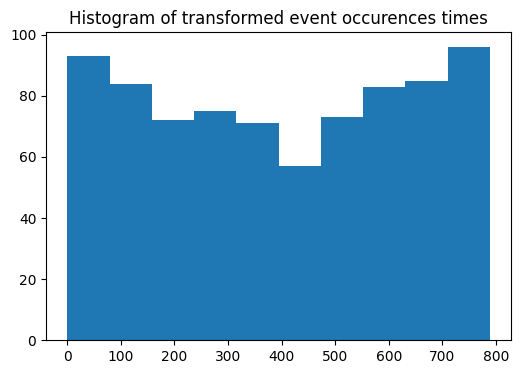

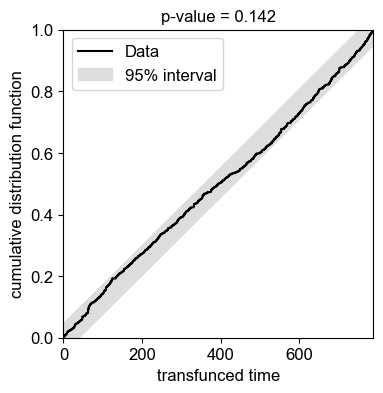

In [4]:
day = datetime(2017, 1, 2)
# "reformat" determines how jumps are handled when mutliple events occur at the same time.
reformat = "delete"

Tx, itv = fit_hawkes_to_trading_day(day=day, reformat=reformat)

print("Reproduced KS test p-value (reformat="+reformat+") :", round(uniform_KS_test(Tx, itv), 3))

Reproduced KS test p-value (reformat=interpolate) : 0.0


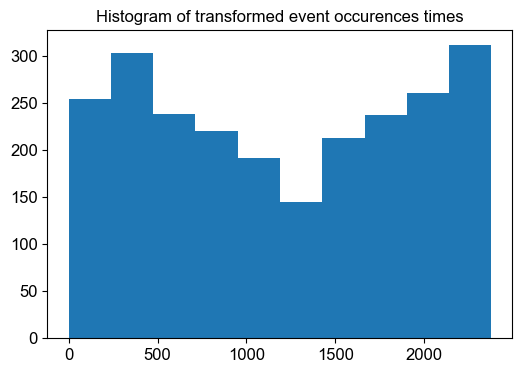

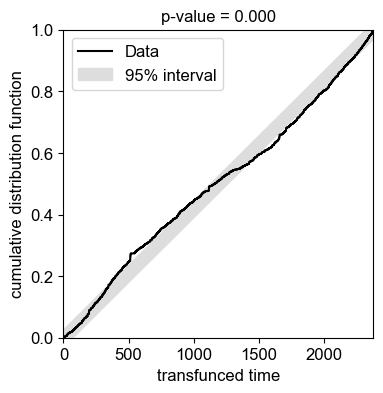

In [5]:
day = datetime(2017, 1, 2)
# "reformat" determines how jumps are handled when mutliple events occur at the same time.
reformat = "interpolate"

Tx, itv = fit_hawkes_to_trading_day(day=day, reformat=reformat)

print("Reproduced KS test p-value (reformat="+reformat+") :", round(uniform_KS_test(Tx, itv), 3))

<u>Removing duplicate jumps.</u>

When removing duplicates in case of multiple jumps occuring at the same time, the p-value is non-zero for most days, but not always above 5%. Therefore, there is some evidence against the chosen Hawkes process accurately describing trading activity.

<u>Keeping duplicate jumps.</u>

When keeping all rows from the trades dataset (and uniformly spreading duplicates when mutilple jumps occur at the same time), the p-value is consistently under 5%. So, the hypothesis of a uniform distribution is significantly rejected. The distribution of trade times during the chosen day is significantly not uniform.

<u>Note:</u> The Kolmogorov-Smirnov test coded by the team and the Hawkes package's return similar p-values, ensuring the validity of our function.

### 1.2. Try different parts of the day and different sample lengths

In [6]:
def test_hawkes_different_times_of_day(
        day:datetime,
        lenghts_minutes:list,
        starts_minutes:list,
        confidence_interval:float,
        reformat: str = "delete"
        )->pd.DataFrame:
    """ 
    Fits a Hawkes process with constant baseline intensity and a single exponential kernel with MLE.
    The fits are realized for different time intervals accros the day (starts_minutes x lengths_minutes).
    Returns the AIC of each combination between 9 am and 5 pm.
    """
    # Load trade times of given day
    times = reformat_arrival_times(day=day, reformat=reformat)
    # Initialise results
    res = pd.DataFrame(dtype=float, columns=["Start Time", "End Time", "AIC", "p value", "Significantly Rejected"])
    # Computation loop on each combination
    n = 0
    for x in lenghts_minutes:
        span = timedelta(minutes=x)
        for s in starts_minutes:
            start_time = day + timedelta(minutes=s)
            start_stamp = start_time.timestamp()-day.timestamp()
            end_time = start_time + span
            # Test if the span is included in trading hours of the day
            if (end_time.time() < time(hour=17)) and (start_time.time() < time(17)) and (end_time.day == day.day):
                end_stamp = (start_time+span).timestamp() - day.timestamp()
                sampled_times = times.loc[times.between(start_stamp, end_stamp)]
                itv = [start_stamp, end_stamp] # [0, T]
                # Fit a hawkes model to the sampled trade times
                model = hk.estimator()
                model.set_kernel('exp', num_exp=1)
                model.set_baseline('const')
                model.fit(sampled_times.values, itv)
                [T_trans, itv_trans] = model.t_trans()
                p_value = uniform_KS_test(T_trans, itv_trans)
                res.loc[n] = {"Start Time": start_time, "End Time": end_time, "AIC":model.AIC, "p value": p_value, "Significantly Rejected": p_value<confidence_interval}
                n += 1
    # Format result table
    res["Timespan"] = res["End Time"] - res["Start Time"]
    res = res.set_index(["Start Time", "End Time"])
    res.sort_values(by="AIC")
    return res


def plot_AICs(AICs:pd.DataFrame, ax=None):
    """Plot AIC values computed for the different time windows across the day (in log-scale)."""
    day = AICs.index.get_level_values(level="Start Time")[0]
    if ax is None:
        _, ax = plt.subplots(figsize=(12,8))
    ax.hlines(y=AICs.values, xmin=AICs.index.get_level_values("Start Time"), xmax=AICs.index.get_level_values("End Time"))
    ax.set_yscale("log")
    ax.set_title("Computed AIC for different timespans ({})".format(day.strftime(format="%Y-%m-%d")))
    ax.set_xlabel("Sampled period of the day")
    ax.set_ylabel("AIC")
    return ax


def color_bin(val:bool):
    if val:
        return "red"
    return "green"


def plot_p_values(p_values:pd.DataFrame, ax=None):
    """Plot p-values computed for the different time windows across the day (in log-scale)."""
    day = p_values.index.get_level_values(level="Start Time")[0]
    if ax is None:
        _, ax = plt.subplots(figsize=(12,8))
    colors=["green", "red"]
    ax.hlines(
        y=p_values["p value"].values, 
        xmin=p_values.index.get_level_values("Start Time"), 
        xmax=p_values.index.get_level_values("End Time"),
        colors=p_values["Significantly Rejected"].apply(color_bin).values
        )
    legend_elements = [Patch(facecolor=color, edgecolor='w') for color in colors]
    ax.legend(handles=legend_elements,
            labels=["Not Rejected", "Rejected Hawkes hypothesis"])
    ax.set_yscale("log")
    ax.set_title("p values and rejected status for different timespans ({})".format(day.strftime(format="%Y-%m-%d")))
    ax.set_xlabel("Sampled period of the day")
    ax.set_ylabel("p value")
    return ax


def plot_AIC_p_values(
        day:datetime,
        lenghts_minutes:list,
        starts_minutes:list,
        confidence_interval:float,
        reformat: str = "delete"
    ):
    """Plot the AIC and p-values for different time windows."""
    # Compute the results
    res = test_hawkes_different_times_of_day(
        day=day,
        lenghts_minutes=lenghts_minutes,
        starts_minutes=starts_minutes,
        confidence_interval=confidence_interval,
        reformat=reformat
    )
    AICs = res[["AIC"]]
    p_values = res[["p value", "Significantly Rejected"]]
    # Plot
    fig, axs = plt.subplots(ncols=2, figsize=(20,8))
    _ = plot_AICs(AICs, ax=axs[0])
    _ = plot_p_values(p_values, ax=axs[1])
    # Figure title
    str_date = day.strftime(format="%Y-%m-%d")
    str_title = "Hawkes model analysis (" + str_date + ", reformat=" + reformat + ")"
    fig.suptitle(str_title)
    return res


def to_time(td:timedelta)->time:
    return time(hour=td.seconds//3600, minute=(td.seconds//60)%60)


def test_stats(
    day:datetime,
    lenghts_minutes:list,
    starts_minutes:list,
    confidence_interval:float,
    reformat: str = "delete"
):
    """For a given time window length (in minutes), compute the proportion of samples passing the uniformity hypothesis test."""
    # Compute the results
    res = test_hawkes_different_times_of_day(
        day=day,
        lenghts_minutes=lenghts_minutes,
        starts_minutes=starts_minutes,
        confidence_interval=confidence_interval,
        reformat=reformat
    )
    success_frequency = pd.DataFrame(dtype=float, columns=["Frequency of passing the test"])
    success_frequency["Frequency of passing the test"] = res.loc[res["Significantly Rejected"]==False]\
        ["Timespan"].value_counts()/res["Timespan"].value_counts()
    success_frequency.index = pd.Series(success_frequency.index).apply(to_time)
    success_frequency.index.name = "Time itv"
    return success_frequency.fillna(0)

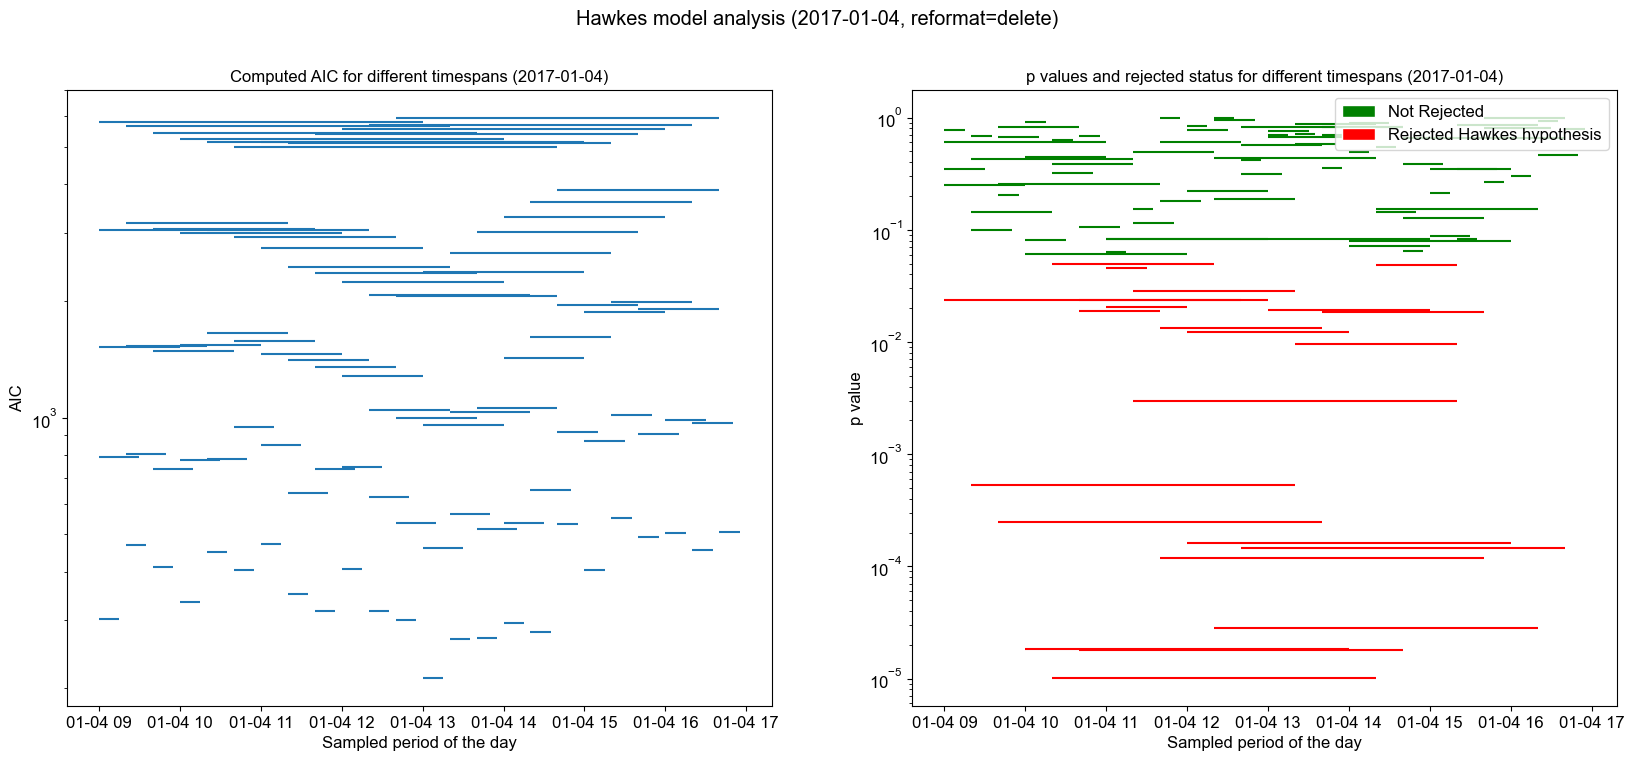

In [7]:
day = datetime(2017, 1, 4, 9)
lenghts_minutes = [15, 30, 60, 120, 240, 480] #range(10, 241, 20)
starts_minutes = range(0, 481, 20)
confidence_interval = 0.05
reformat = "delete"

res = plot_AIC_p_values(
    day=day,
    lenghts_minutes=lenghts_minutes,
    starts_minutes=starts_minutes,
    confidence_interval=confidence_interval,
    reformat=reformat
)

In [8]:
success_frequencies = test_stats(
    day=day,
    lenghts_minutes=lenghts_minutes,
    starts_minutes=starts_minutes,
    confidence_interval=confidence_interval,
    reformat=reformat
)
success_frequencies

,Frequency of passing the test
Time itv,
00:15:00,1.000000
00:30:00,0.956522
01:00:00,0.857143
02:00:00,0.555556
04:00:00,0.083333


In [9]:
# Timespans which uniformity test has not been rejected (top 10 p-values):
res.loc[res["Significantly Rejected"]==False].sort_values(by="p value", ascending=False).head(10)

,,AIC,p value,Significantly Rejected,Timespan
Start Time,End Time,,,,
2017-01-04 11:40:00,2017-01-04 11:55:00,316.150868,0.998824,False,0 days 00:15:00
2017-01-04 12:20:00,2017-01-04 12:35:00,317.226535,0.994847,False,0 days 00:15:00
2017-01-04 15:40:00,2017-01-04 16:40:00,1906.821091,0.990182,False,0 days 01:00:00
2017-01-04 12:20:00,2017-01-04 12:50:00,624.562265,0.961442,False,0 days 00:30:00
2017-01-04 16:20:00,2017-01-04 16:35:00,456.233569,0.927144,False,0 days 00:15:00
2017-01-04 10:00:00,2017-01-04 10:15:00,335.081229,0.921159,False,0 days 00:15:00
2017-01-04 14:00:00,2017-01-04 14:30:00,535.633429,0.903040,False,0 days 00:30:00
2017-01-04 13:20:00,2017-01-04 14:20:00,1032.201982,0.883885,False,0 days 01:00:00
2017-01-04 15:20:00,2017-01-04 16:20:00,1983.842851,0.860935,False,0 days 01:00:00


<b><u>Comments.</b></u>

The AIC values are generally smaller for shorter timespans : Hawkes fit is better on a short period of time during a trading day. 

This is confirmed by the fact that the frequency of rejecting the null hypothesis increases as the timespan increases. All 15 minutes tests passed.

There is a noticeable better fit for the Hawkes process around noon, regardless of the length of time tested.

The frequency of passing the Kolmogorov-Smirnov test is a decreasing function of the timespan.

<b><u>Conclusion:</u> The Hawkes model with a constant baseline intensity and a kernel with one exponential is more adapted to shorter timespans.</b>

<a id='q2'></a>

## 2. Systematic Analysis [[^]](#top)

### 2.1. Fit a Hawkes process for different baseline functions, varying number of exponential kernels and different sample sizes for each day.